In [1]:
import numpy as np
import pandas as pd
import cv2
import os

from tqdm import tqdm
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn import metrics

import random

2024-05-15 08:02:48.393260: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 08:02:48.393366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 08:02:48.516781: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# This cells is made to set the different directories used in this notebook
groups = ['COVID-19', 'Normal', 'Non-COVID']
sets = ['Val', 'Test', 'Train']
# Define base path
base_path = '/kaggle/input/covidqu/Lung Segmentation Data/Lung Segmentation Data' #Chemin jusqu'aux dossiers Test Train Val
destination_path = '/kaggle/working/COVID-EX-Qu-dataset'

In [3]:
# Only run this cell if working files are not in kaggle working directory
import shutil

for sett in sets:
  for group in groups:
    ima_dir = os.path.join(base_path, sett, group)
    for dos in tqdm(os.listdir(ima_dir)):
        if dos=="images":
            shutil.copytree(os.path.join(ima_dir, dos), os.path.join(destination_path, sett, group, dos))

100%|██████████| 2/2 [00:42<00:00, 21.00s/it]


In [4]:
# Checking data integrity after Kaggle input to output directory
n_covid = 0
n_noncovid = 0
n_normal = 0
#----Reference number from COVID-EX-qu Kaggle------------
ref_covid = 11956
ref_noncovid = 11263
ref_normal = 10701
#-------------------------------------------------------
for sett in sets:
  for group in groups:
    ima_dir = os.path.join(destination_path, sett, group)
    for dos in os.listdir(ima_dir):
      num = len(os.listdir(os.path.join(ima_dir, dos)))
      print(f"In the set {sett}, there are {num} {dos} of {group}")
      if group =="COVID-19" and dos=='images':
        n_covid += len(os.listdir(os.path.join(ima_dir, dos)))
      if group =="Non-COVID" and dos=='images':
        n_noncovid += len(os.listdir(os.path.join(ima_dir, dos)))
      if group =="Normal" and dos=='images':
        n_normal += len(os.listdir(os.path.join(ima_dir, dos)))

print(f"\nThere are {n_covid} COVID images found, {n_covid/ref_covid *100}% of the original dataset from Kaggle.")
print(f"There are {n_noncovid} non-COVID images, {n_noncovid/ref_noncovid *100}% of the original dataset from Kaggle.")
print(f"There are {n_normal} normal images, {n_normal/ref_normal *100}% of the original dataset from Kaggle.")

In the set Val, there are 1903 images of COVID-19
In the set Val, there are 1712 images of Normal
In the set Val, there are 1802 images of Non-COVID
In the set Test, there are 2395 images of COVID-19
In the set Test, there are 2140 images of Normal
In the set Test, there are 2253 images of Non-COVID
In the set Train, there are 7658 images of COVID-19
In the set Train, there are 6849 images of Normal
In the set Train, there are 7208 images of Non-COVID

There are 11956 COVID images found, 100.0% of the original dataset from Kaggle.
There are 11263 non-COVID images, 100.0% of the original dataset from Kaggle.
There are 10701 normal images, 100.0% of the original dataset from Kaggle.


In [5]:
# Checking if GPU is activated
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
from tensorflow.keras.applications.xception import preprocess_input # Preprocess for XCeption model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_image(img):
    '''This function normalizes images by equalizing histograms (grayscale only)'''
    
    # Convert image to grayscale if it's not already
    if len(img.shape) == 3 and img.shape[2] == 3:  # RGB image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Ensure image is of type uint8
    img = img.astype('uint8')
    # Equalize histogram
    img = cv2.equalizeHist(img)
    # Convert grayscale back to RGB
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # Preprocess for the model input
    img_preprocessed = preprocess_input(img)
    return img_preprocessed


# Instanciation of image data generators using the preprocessing function defined before

train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_image) 
val_data_generator = ImageDataGenerator(preprocessing_function = preprocess_image)
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_image)

In [7]:
# Preprocessing of each folder

batch_size = 32
train_generator = train_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Train'),
                                                           classes=['COVID-19', 'Normal', 'Non-COVID'],
                                                           class_mode="sparse",
                                                           target_size=(299, 299),
                                                           batch_size=batch_size)

val_generator = test_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Val'),
                                                        classes=['COVID-19', 'Normal', 'Non-COVID'],
                                                         class_mode="sparse",
                                                         target_size=(299, 299),
                                                         batch_size=batch_size)

test_generator = test_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Test'),
                                                         classes=['COVID-19', 'Normal', 'Non-COVID'],
                                                          class_mode="sparse",
                                                          target_size=(299, 299),
                                                          batch_size=batch_size, shuffle=False)

nb_img_train = train_generator.samples
nb_img_val = val_generator.samples

Found 21715 images belonging to 3 classes.
Found 5417 images belonging to 3 classes.
Found 6788 images belonging to 3 classes.


In [8]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
    
# Initializing Xception model with pre-trained weights, without the specific top layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freezing 
for layer in base_model.layers: 
    layer.trainable = False

# Add final layers to the model
XCeption_base = Sequential()
XCeption_base.add(base_model)
XCeption_base.add(GlobalAveragePooling2D())
XCeption_base.add(Dense(512, activation='relu'))
XCeption_base.add(Dropout(rate=0.3))
XCeption_base.add(Dense(256, activation='relu'))
XCeption_base.add(Dropout(rate=0.4))
XCeption_base.add(Dense(3, activation='softmax'))

# Model compilation
XCeption_base.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
def application_masks(image,mask):
    '''This function applies a "mask" to an "image" and returns the masked_image.
    The goal is to keep only the lungs for the model'''
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image
        
masks_applicated = "masks_applicated"

for folder in sets:
    for group in groups:
        ima_dir = os.path.join(base_path, folder, group, "images")
        mask_dir = os.path.join(base_path, folder, group, "lung masks")
    
        masks_applicated_path = os.path.join(destination_path, folder, group, masks_applicated)
    
        if not os.path.exists(masks_applicated_path):
            os.mkdir(masks_applicated_path) # Creating the new folder if it does not exist
        else :
            print("Pre-existing folder")
        
        for image in tqdm(os.listdir(ima_dir)):
            image_path = os.path.join(ima_dir, image) # Path to image
            image_read = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            mask_path = os.path.join(mask_dir, image) # Path to mask with an identical name to the image
            mask_read = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            result_image = application_masks(image_read, mask_read) # Creation of the masked image
            result_image_path = os.path.join(destination_path, folder, group, masks_applicated, image) # Path to the masked image
        
            cv2.imwrite(result_image_path, result_image)

100%|██████████| 7208/7208 [00:53<00:00, 135.81it/s]


In [10]:
# Moving the masked images as flow_from_directory can't deal with several folders within the label folders

mask_destination_path = '/kaggle/working/COVID-EX-Qu-dataset-mask'

for sett in sets:
    for group in groups:
        ima_dir = os.path.join(destination_path, sett, group)
        for dos in tqdm(os.listdir(ima_dir)):
            if dos=="masks_applicated":
                shutil.move(os.path.join(destination_path, sett, group, dos), os.path.join(mask_destination_path, sett, group, dos))

100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


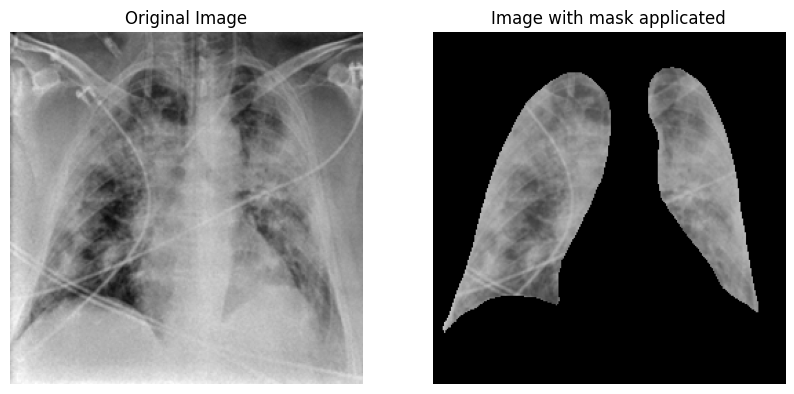

In [11]:
# Visual confirmation of the application of masks:
sett = random.choice(sets)
group = random.choice(groups)

directory_path = os.path.join(destination_path, sett, group, 'images')
files = os.listdir(directory_path)
random_file = random.choice(files)
image_path = os.path.join(directory_path, random_file)
image = cv2.imread(image_path)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

directory_path_mask = os.path.join(mask_destination_path, sett, group, 'masks_applicated')
masked_image_path = os.path.join(directory_path_mask, random_file)
masked_image = cv2.imread(masked_image_path)
gray_masked_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(gray_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(gray_masked_image, cv2.COLOR_GRAY2RGB))
axes[1].set_title('Image with mask applicated')
axes[1].axis('off')
plt.show()

In [12]:
# Preprocessing of each "mask" folder

train_generator_mask = train_data_generator.flow_from_directory(directory=os.path.join(mask_destination_path, 'Train'),
                                                           classes=['COVID-19', 'Normal', 'Non-COVID'],
                                                           class_mode="sparse",
                                                           target_size=(299, 299),
                                                           batch_size=batch_size)

val_generator_mask = test_data_generator.flow_from_directory(directory=os.path.join(mask_destination_path, 'Val'),
                                                        classes=['COVID-19', 'Normal', 'Non-COVID'],
                                                         class_mode="sparse",
                                                         target_size=(299, 299),
                                                         batch_size=batch_size)

test_generator_mask = test_data_generator.flow_from_directory(directory=os.path.join(mask_destination_path, 'Test'),
                                                         classes=['COVID-19', 'Normal', 'Non-COVID'],
                                                          class_mode="sparse",
                                                          target_size=(299, 299),
                                                          batch_size=batch_size, shuffle=False)

Found 21715 images belonging to 3 classes.
Found 5417 images belonging to 3 classes.
Found 6788 images belonging to 3 classes.


In [13]:
# Creating the model for the masked images - The dropout rate will be increased as overfitting was observed on the previous tests
XCeption_mask3 = Sequential()
XCeption_mask3.add(base_model)
XCeption_mask3.add(GlobalAveragePooling2D())
XCeption_mask3.add(Dense(512, activation='relu'))
XCeption_mask3.add(Dropout(rate=0.5)) # Help prevent overfitting
XCeption_mask3.add(Dense(256, activation='relu'))
XCeption_mask3.add(Dropout(rate=0.5)) # Help prevent overfitting
XCeption_mask3.add(Dense(3, activation='softmax'))

# Model compilation
XCeption_mask3.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Mask model will be unfrozen on the Middle & Exit Flow (best of the 2 previous models)
for layer in XCeption_mask3.layers[0].layers[36:]:
    layer.trainable = True

nb_img_train_mask = train_generator_mask.samples
nb_img_val_mask = val_generator_mask.samples

In [14]:
# Model training
history_Xception_mask3 = XCeption_mask3.fit(train_generator_mask, 
                                epochs = 20,
                                steps_per_epoch = nb_img_train_mask//batch_size,
                                validation_data=val_generator_mask,
                                validation_steps=nb_img_val_mask//batch_size
                                )

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1715760682.399123      89 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715760682.463821      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.7353 - loss: 0.6583

W0000 00:00:1715760914.178057      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


678/678 ━━━━━━━━━━━━━━━━━━━━ 304s 372ms/step - accuracy: 0.7353 - loss: 0.6581 - val_accuracy: 0.8132 - val_loss: 0.4999
Epoch 2/20
  1/678 ━━━━━━━━━━━━━━━━━━━━ 3:18 293ms/step - accuracy: 0.7812 - loss: 0.5834

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


678/678 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7812 - loss: 0.5834 - val_accuracy: 1.0000 - val_loss: 0.1927
Epoch 3/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 222s 327ms/step - accuracy: 0.8338 - loss: 0.4360 - val_accuracy: 0.8796 - val_loss: 0.3605
Epoch 4/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 85us/step - accuracy: 0.8750 - loss: 0.3387 - val_accuracy: 1.0000 - val_loss: 0.1462
Epoch 5/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 222s 327ms/step - accuracy: 0.8602 - loss: 0.3686 - val_accuracy: 0.7923 - val_loss: 0.5418
Epoch 6/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 85us/step - accuracy: 0.8750 - loss: 0.2331 - val_accuracy: 0.6667 - val_loss: 0.4564
Epoch 7/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 222s 327ms/step - accuracy: 0.8845 - loss: 0.3165 - val_accuracy: 0.8585 - val_loss: 0.3808
Epoch 8/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 93us/step - accuracy: 0.9375 - loss: 0.1535 - val_accuracy: 0.8889 - val_loss: 0.1641
Epoch 9/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 222s 326ms/step - accuracy: 0.8961 - loss: 0.2750 - val_accu

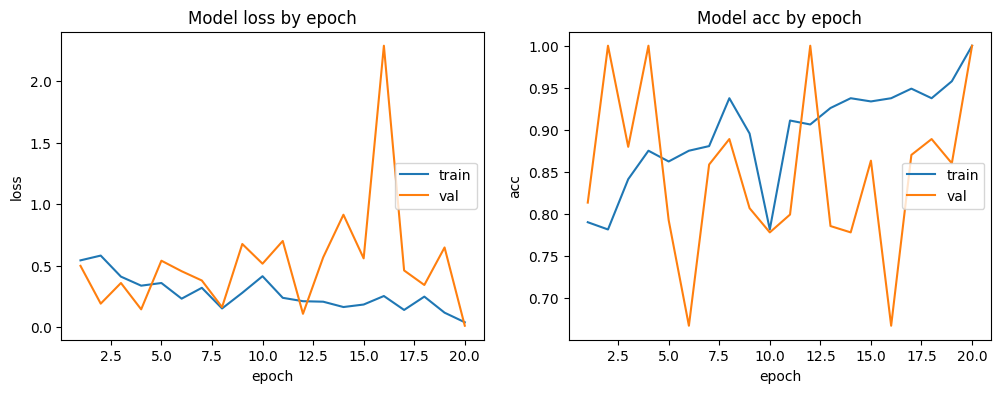

In [15]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(np.arange(1,21,1), history_Xception_mask3.history['loss'])
plt.plot(np.arange(1,21,1), history_Xception_mask3.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')

plt.subplot(122)
plt.plot(np.arange(1,21,1), history_Xception_mask3.history['accuracy'])
plt.plot(np.arange(1,21,1), history_Xception_mask3.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()

In [16]:
evaluation_mask3 = XCeption_mask3.evaluate(test_generator_mask)

# Print the evaluation metrics
print("Test Loss:", evaluation_mask3[0])
print("Test Accuracy:", evaluation_mask3[1])

213/213 ━━━━━━━━━━━━━━━━━━━━ 30s 140ms/step - accuracy: 0.8323 - loss: 0.8600
Test Loss: 0.6335688829421997
Test Accuracy: 0.8716853260993958


In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss',
                                         patience=10,
                                         mode='min',
                                         restore_best_weights=True)

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3, #si val_loss stagne sur 3 epochs consécutives selon la valeur min_delta
                                    min_delta= 0.01,
                                    factor=0.1,  # On réduit le learning rate d'un facteur 0.1
                                    cooldown = 4, # On attend 4 epochs avant de réitérer 
                                    verbose=1)

In [18]:
# Creating the model for the masked images - The dropout rate will be increased as overfitting was observed on the previous tests
XCeption_mask4 = Sequential()
XCeption_mask4.add(base_model)
XCeption_mask4.add(GlobalAveragePooling2D())
XCeption_mask4.add(Dense(512, activation='relu'))
XCeption_mask4.add(Dropout(rate=0.5)) # Help prevent overfitting
XCeption_mask4.add(Dense(256, activation='relu'))
XCeption_mask4.add(Dropout(rate=0.5)) # Help prevent overfitting
XCeption_mask4.add(Dense(3, activation='softmax'))

# Model compilation
XCeption_mask4.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Mask model will be unfrozen on the Middle & Exit Flow (best of the 2 previous models)
for layer in XCeption_mask4.layers[0].layers[36:]:
    layer.trainable = True

In [19]:
# Model training
history_Xception_mask4 = XCeption_mask4.fit(train_generator_mask, 
                                epochs = 20,
                                steps_per_epoch = nb_img_train_mask//batch_size,
                                validation_data=val_generator_mask,
                                validation_steps=nb_img_val_mask//batch_size,
                                callbacks = [early_stopping, reduce_learning_rate]
                                )

Epoch 1/20


W0000 00:00:1715763015.928008      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9550 - loss: 0.1557

W0000 00:00:1715763233.582382      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


678/678 ━━━━━━━━━━━━━━━━━━━━ 271s 351ms/step - accuracy: 0.9551 - loss: 0.1556 - val_accuracy: 0.8805 - val_loss: 0.4547 - learning_rate: 0.0010
Epoch 2/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9375 - loss: 0.3233 - val_accuracy: 1.0000 - val_loss: 0.0794 - learning_rate: 0.0010
Epoch 3/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 222s 326ms/step - accuracy: 0.9744 - loss: 0.0771 - val_accuracy: 0.8291 - val_loss: 1.3603 - learning_rate: 0.0010
Epoch 4/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 87us/step - accuracy: 1.0000 - loss: 0.0068 - val_accuracy: 0.7778 - val_loss: 1.9771 - learning_rate: 0.0010
Epoch 5/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9757 - loss: 0.0724
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
678/678 ━━━━━━━━━━━━━━━━━━━━ 221s 325ms/step - accuracy: 0.9757 - loss: 0.0725 - val_accuracy: 0.7973 - val_loss: 0.8481 - learning_rate: 0.0010
Epoch 6/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 88us/step - accuracy: 1.0000 - loss: 0.01

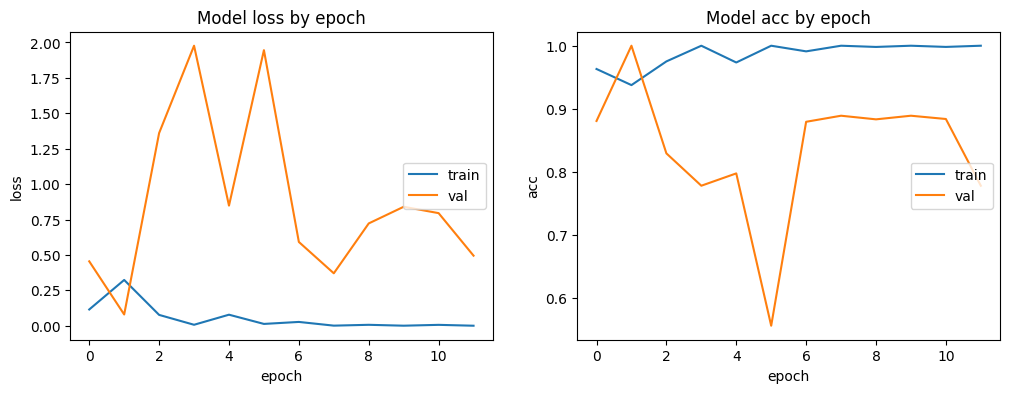

In [20]:
num_epochs4 = len(history_Xception_mask4.history)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history_Xception_mask4.history['loss'])
plt.plot(history_Xception_mask4.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')

plt.subplot(122)
plt.plot(history_Xception_mask4.history['accuracy'])
plt.plot(history_Xception_mask4.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()

In [21]:
evaluation_mask4 = XCeption_mask4.evaluate(test_generator_mask)

# Print the evaluation metrics
print("Test Loss:", evaluation_mask4[0])
print("Test Accuracy:", evaluation_mask4[1])

213/213 ━━━━━━━━━━━━━━━━━━━━ 27s 128ms/step - accuracy: 0.9038 - loss: 0.4054
Test Loss: 0.4240904748439789
Test Accuracy: 0.8948143720626831


Gain de 2-3 points grace aux callbacks.
Le meilleur modèle de masques va être récupérés pour les callbacks.

In [22]:
XCeption_mask5 = XCeption_base
for layer in XCeption_mask5.layers[0].layers[36:]:
    layer.trainable = True

In [23]:
# Model training
history_Xception_mask5 = XCeption_mask5.fit(train_generator_mask, 
                                epochs = 20,
                                steps_per_epoch = nb_img_train_mask//batch_size,
                                validation_data=val_generator_mask,
                                validation_steps=nb_img_val_mask//batch_size,
                                callbacks = [early_stopping, reduce_learning_rate]
                                )

Epoch 1/20


W0000 00:00:1715764440.400050      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.9604 - loss: 0.1341

W0000 00:00:1715764659.294870      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


678/678 ━━━━━━━━━━━━━━━━━━━━ 273s 353ms/step - accuracy: 0.9605 - loss: 0.1340 - val_accuracy: 0.8428 - val_loss: 0.6469 - learning_rate: 0.0010
Epoch 2/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 0.0243 - val_accuracy: 0.6667 - val_loss: 1.0346 - learning_rate: 0.0010
Epoch 3/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 222s 326ms/step - accuracy: 0.9799 - loss: 0.0645 - val_accuracy: 0.8676 - val_loss: 0.5139 - learning_rate: 0.0010
Epoch 4/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 1s 308us/step - accuracy: 0.9375 - loss: 0.1842 - val_accuracy: 1.0000 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 5/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 222s 326ms/step - accuracy: 0.9797 - loss: 0.0576 - val_accuracy: 0.8386 - val_loss: 0.6939 - learning_rate: 0.0010
Epoch 6/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 90us/step - accuracy: 0.9688 - loss: 0.1034 - val_accuracy: 0.7778 - val_loss: 0.5026 - learning_rate: 0.0010
Epoch 7/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9834 - loss: 0.0

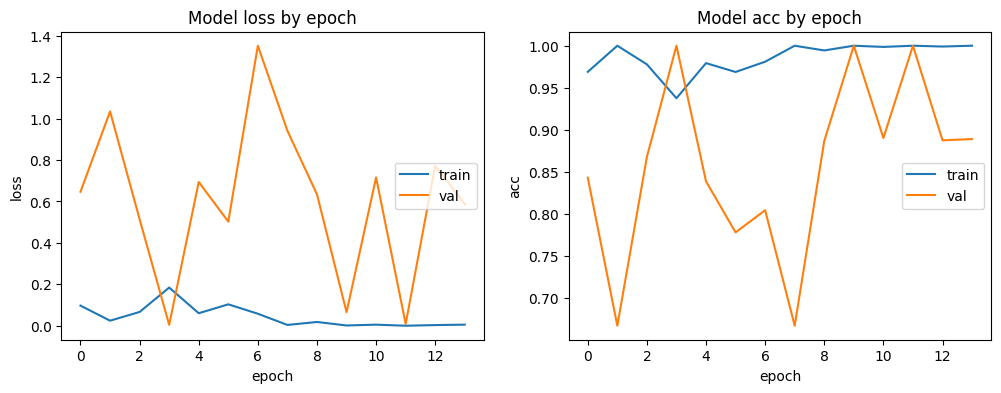

In [24]:
num_epochs5 = len(history_Xception_mask5.history)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history_Xception_mask5.history['loss'])
plt.plot(history_Xception_mask5.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')

plt.subplot(122)
plt.plot(history_Xception_mask5.history['accuracy'])
plt.plot(history_Xception_mask5.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()

In [25]:
evaluation_mask5 = XCeption_mask5.evaluate(test_generator_mask)

# Print the evaluation metrics
print("Test Loss:", evaluation_mask5[0])
print("Test Accuracy:", evaluation_mask5[1])

213/213 ━━━━━━━━━━━━━━━━━━━━ 28s 129ms/step - accuracy: 0.8902 - loss: 0.4566
Test Loss: 0.44852250814437866
Test Accuracy: 0.8873011469841003


Callbacks sur le meilleur modèle non masqué

In [26]:
XCeption_callbacks = XCeption_base
for layer in XCeption_callbacks.layers[0].layers[36:]:
    layer.trainable = True

In [27]:
# Model training
history_Xception_callbacks = XCeption_callbacks.fit(train_generator, 
                                epochs = 20,
                                steps_per_epoch = nb_img_train//batch_size,
                                validation_data=val_generator,
                                validation_steps=nb_img_val//batch_size,
                                callbacks = [early_stopping, reduce_learning_rate]
                                )

Epoch 1/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 224s 328ms/step - accuracy: 0.8003 - loss: 0.7368 - val_accuracy: 0.8406 - val_loss: 0.4572 - learning_rate: 1.0000e-05
Epoch 2/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 86us/step - accuracy: 0.9062 - loss: 0.2354 - val_accuracy: 0.7778 - val_loss: 0.4300 - learning_rate: 1.0000e-05
Epoch 3/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 223s 328ms/step - accuracy: 0.8580 - loss: 0.3811 - val_accuracy: 0.8563 - val_loss: 0.3904 - learning_rate: 1.0000e-05
Epoch 4/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 94us/step - accuracy: 0.8438 - loss: 0.3747 - val_accuracy: 1.0000 - val_loss: 0.1033 - learning_rate: 1.0000e-05
Epoch 5/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 223s 328ms/step - accuracy: 0.8764 - loss: 0.3200 - val_accuracy: 0.8665 - val_loss: 0.3624 - learning_rate: 1.0000e-05
Epoch 6/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 87us/step - accuracy: 0.8750 - loss: 0.4079 - val_accuracy: 0.7778 - val_loss: 0.2625 - learning_rate: 1.0000e-05
Epoch 7/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/

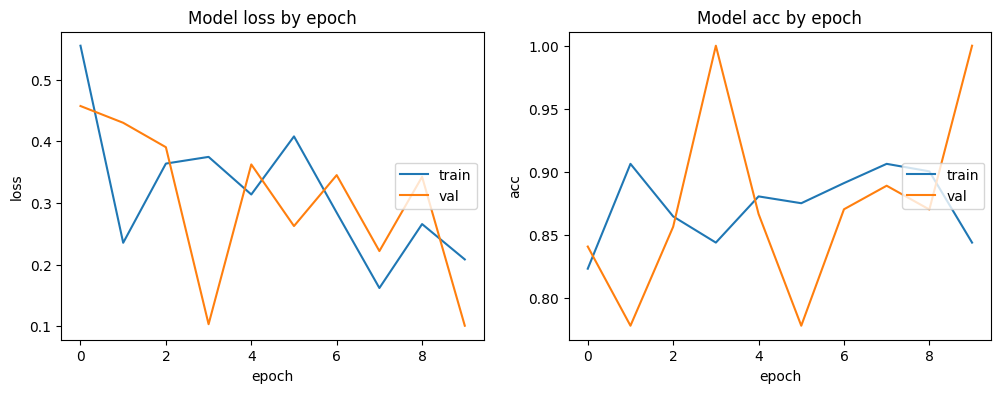

In [28]:
num_epochs_callbacks = len(history_Xception_callbacks.history)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history_Xception_callbacks.history['loss'])
plt.plot(history_Xception_callbacks.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')

plt.subplot(122)
plt.plot(history_Xception_callbacks.history['accuracy'])
plt.plot(history_Xception_callbacks.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()

In [29]:
evaluation_callbacks = XCeption_callbacks.evaluate(test_generator)

# Print the evaluation metrics
print("Test Loss:", evaluation_callbacks[0])
print("Test Accuracy:", evaluation_callbacks[1])

213/213 ━━━━━━━━━━━━━━━━━━━━ 28s 132ms/step - accuracy: 0.8670 - loss: 0.3655
Test Loss: 0.4640810191631317
Test Accuracy: 0.8372127413749695
